In [1]:
# -*- coding: utf8

from scipy import stats as ss
from sklearn import datasets

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## Aula 21 - Logística

Temos um conjunto de dados anônimos de aproximadamente 284 lances do jogador Lebron James. Como é comum em variáveis categóricas, representamos a variável dependente como 0 (errou a cesta) ou 1 (acertou a cesta). Esta será a nossa resposta que queremos prever. 

In [4]:
df = pd.read_csv('./lebron.csv')
df.head()

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
3,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0,1
4,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0,1


In [5]:
df.shape

(384, 7)

Vamos iniciar observando a quantidade de acertos por distância da cesta.

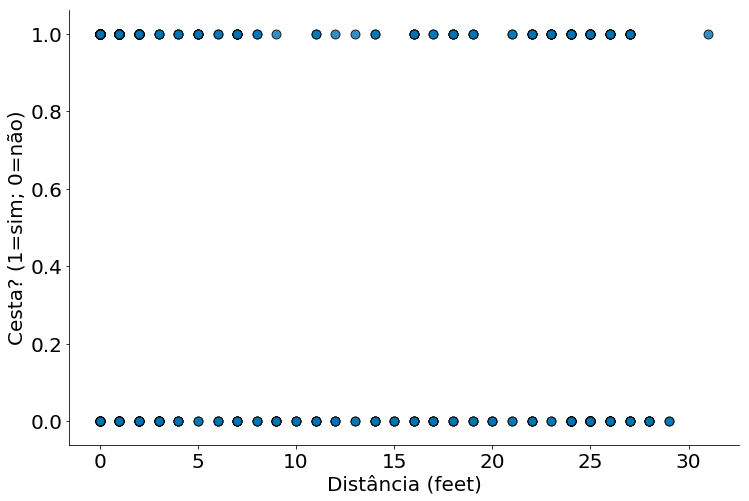

In [6]:
n = df.shape[0]
plt.scatter(df['shot_distance'],
            df['shot_made'],
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

Adicionando algum ruído para melhorar o plot. Observe como os dados se concentram do lado esquerdo.

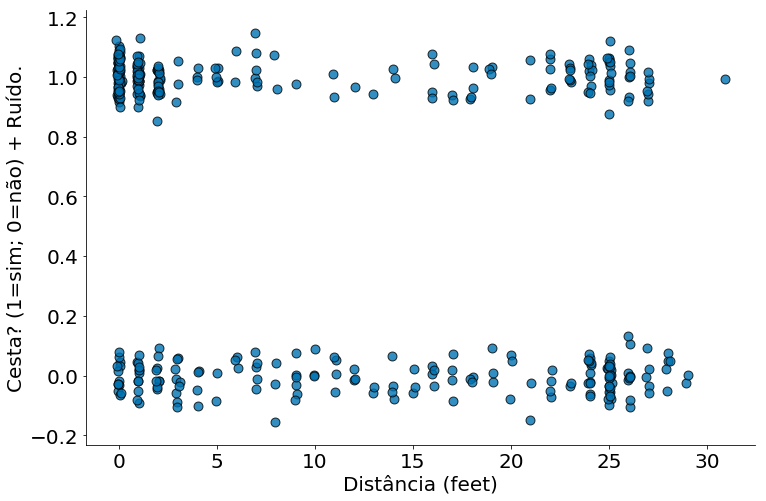

In [7]:
n = df.shape[0]
plt.scatter(df['shot_distance'] + np.random.normal(0, 0.05, size=n),
            df['shot_made'] + np.random.normal(0, 0.05, size=n),
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não) + Ruído.')
despine()

Como identificar quando Lebron acerta ou erra? Uma primeira tentativa óbvia é usar regressão linear e encontrar o melhor modelo. Observe como a mesma tenta capturar os locais de maior concentração de pontos.

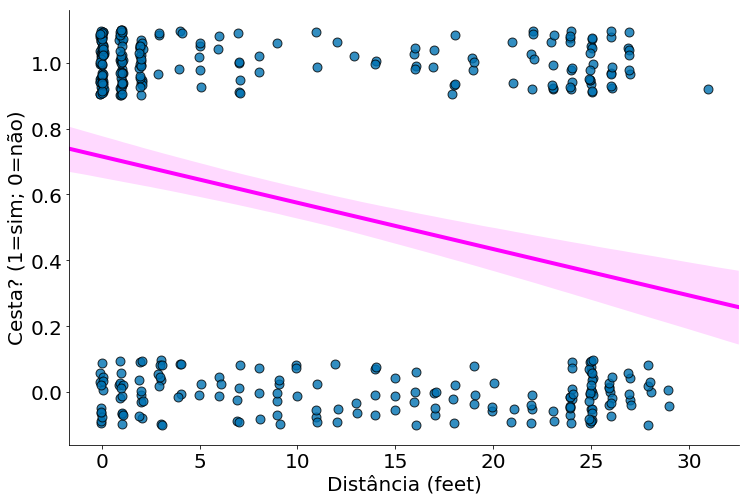

In [8]:
sns.regplot(x='shot_distance', y='shot_made', data=df, n_boot=10000,
            x_jitter=.1, y_jitter=.1,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

O resultado é uma curva com inclinação negativa.

In [9]:
ss.linregress(df['shot_distance'], df['shot_made'])

LinregressResult(slope=-0.014055196583349789, intercept=0.71542888637452495, rvalue=-0.29865301020530832, pvalue=2.3711855177639454e-09, stderr=0.0022980071639352555)

Mas essa abordagem leva a alguns problemas imediatos:

* Gostaríamos que nossos resultados previstos fossem 0 ou 1. Tudo bem se eles estiverem entre 0 e 1, já que podemos interpretá-los como probabilidades - uma saída de 0,25 pode significar 25% de chance de ser um membro que paga. Mas as saídas do modelo linear podem ser números positivos enormes ou até números negativos, o que não fica claro como interpretar.

* O que gostaríamos, ao contrário, é que valores positivos grandes de $\mathbf{x_i}~ . \mathbf{\theta}$ (ou `np.dot(x_i,theta)`) correspondam a probabilidades próximas a 1 e que valores negativos grandes correspondam a probabilidades próximas a 0. Podemos conseguir isso aplicando outra função ao resultado.

## A Função Logística

No caso da regressão logística, a gente usa a função logística:

In [10]:
def sigmoid(X, theta):
    return 1.0 / (1.0 + np.exp(-X.dot(theta)))

À medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

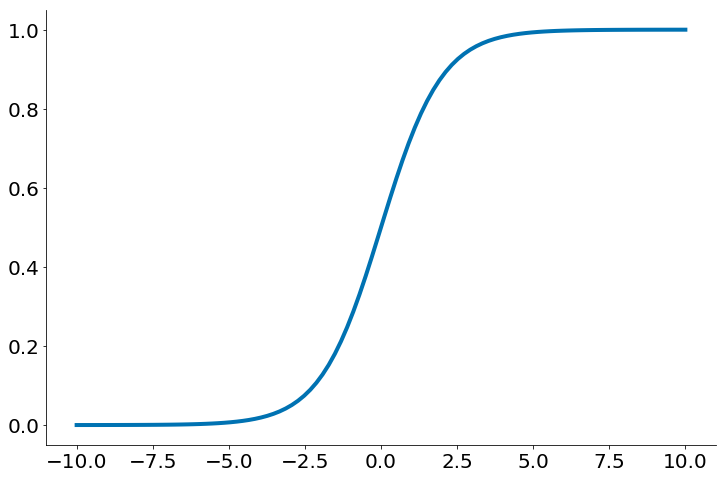

In [11]:
X = np.linspace(-10, 10, 100)[:, None] # vira um vetor coluna
y = sigmoid(X, theta=np.array([1]))
plt.plot(X, y)
despine()

À medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Podemos inverter a mesma alterando o valor de theta.

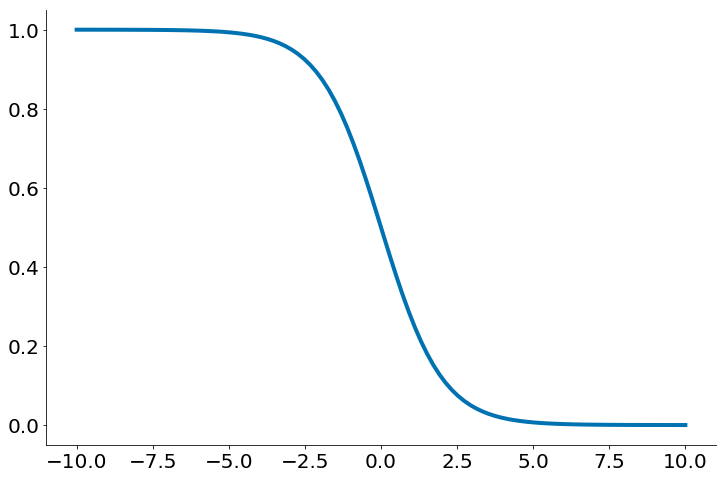

In [12]:
X = np.linspace(-10, 10, 100)[:, None] # vira um vetor coluna
y = sigmoid(X, theta=np.array([-1]))
plt.plot(X, y)
despine()

Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

In [13]:
def logistic_prime(X, theta):
    return sigmoid(X, theta) * (1 - sigmoid(X, theta))

Oberseve a derivada em cada ponto.

In [14]:
logistic_prime(X, np.array([1]))

array([  4.53958077e-05,   5.55575620e-05,   6.79936937e-05,
         8.32130942e-05,   1.01838442e-04,   1.24631609e-04,
         1.52524715e-04,   1.86658091e-04,   2.28426653e-04,
         2.79536554e-04,   3.42074339e-04,   4.18591319e-04,
         5.12206458e-04,   6.26731702e-04,   7.66824507e-04,
         9.38173215e-04,   1.14772200e-03,   1.40394326e-03,
         1.71716676e-03,   2.09997591e-03,   2.56768332e-03,
         3.13889855e-03,   3.83620191e-03,   4.68693782e-03,
         5.72413978e-03,   6.98759437e-03,   8.52504404e-03,
         1.03935138e-02,   1.26607241e-02,   1.54065171e-02,
         1.87241696e-02,   2.27213903e-02,   2.75206964e-02,
         3.32587242e-02,   4.00838615e-02,   4.81513998e-02,
         5.76152215e-02,   6.86149280e-02,   8.12573764e-02,
         9.55919842e-02,   1.11580066e-01,   1.29060077e-01,
         1.47712989e-01,   1.67034879e-01,   1.86326443e-01,
         2.04710159e-01,   2.21183725e-01,   2.34711795e-01,
         2.44347497e-01,

Daqui a pouco vamos usar a mesma para ajustar um modelo:

$$y_i = f(x_i\theta) + \epsilon_i$$

onde $f$ é a função logística (`logistic`).

Note também que $x_i\theta$, para $j$ variáveis independentes, nada mais é que o modelo linear visto nas aulas anteriores, que é calculado e dado como entrada para a função logística:

$$x_i\theta = \theta_0 + \theta_1 x_1 + \cdots + \theta_j x_j$$

Lembre-se de que, para a regressão linear, ajustamos o modelo minimizando a soma dos erros quadrados, o que acaba escolhendo o $\theta$ que maximiza a probabilidade dos dados.

Aqui os dois não são equivalentes, por isso usaremos gradiente descendente para maximizar a verossimilhança diretamente. Isso significa que precisamos calcular a função de verossimilhança e seu gradiente.

Dado algum $\theta$, nosso modelo diz que cada $y_i$ deve ser igual a 1 com probabilidade $f(x_i\theta)$ e 0 com probabilidade $1 - f(x_i\theta)$.

Em particular, a PDF para $y_i$ pode ser escrita como:

$$p(y_i~|~x_i,\theta) = f(x_i\theta)^{y_i}(1-f(x_i\theta))^{1-y_i}$$

Se $y_i$ é $0$, isso é igual a:

$$1-f(x_i\theta)$$

e se $y_i$ é $1$, é igual a:

$$f(x_i\theta)$$

Acontece que é realmente mais simples maximizar o logaritmo da verossimilhança (*log likelihood*):

$$\log L(\theta~|~x_i,y_i) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$

Como o logaritmo é uma função estritamente crescente, qualquer $\theta$ que maximize o logaritmo da verossimilhança também maximiza a verossimilhança, e vice-versa.

## Cross Entropy

Ao invés de trabalhar na verossimilhança, vamos inverter a mesma (negar). Esta é a definição de cross entropy para a regressão logística. Nos slides da aula derivamos a equivalência entre as duas. [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing).

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log_2(1-f_{\theta}(x_i)) + y_i\log_2(f_{\theta}(x_i))\big)$$

A equação acima é a cross-entropy média por observação.

In [15]:
def cross_entropy_one_sample(x_i, y_i, theta):
    # também podemos escrever y_i * np.log(sigmoid(np.dot(x_i, beta)))
    if y_i == 1:
        return -np.log(sigmoid(np.dot(x_i, theta)))
    else:
        return -np.log(1 - sigmoid(np.dot(x_i, theta)))

In [16]:
def cross_entropy_mean(X, y, theta):
    ones = y > 0.5
    ce  =  np.log(sigmoid(X[ones], theta)).sum()      # positivos
    ce +=  np.log(1 - sigmoid(X[~ones], theta)).sum() # negativos
    return -ce / len(y) # média

A derivada da mesma tem uma forma similar ao da regressão linear. Veja a derivação nos [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). Partindo da derivada da logística acima, chegamos em:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big)
$$

Simplificando:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i (y_i - f_{\theta}(x_i)) x_i
$$

Escrevendo em forma vetorizada. Caso não entenda, veja o material da regressão linear múltipla.

In [17]:
def derivadas(theta, X, y):
    return -((y - sigmoid(X, theta)) * X.T).mean(axis=1)

Podemos otimizar por gradiente descendente.

In [18]:
def gd(d_fun, X, y, lambda_=0.01, tol=0.0000001, max_iter=10000):
    theta = np.ones(X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = d_fun(theta, X, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err = cross_entropy_mean(X, y, theta)
        if np.abs(old_err - err) <= tol:
            break
        theta = theta_novo
        old_err = err
        print('Iter {}; theta = {}; cross_e = {}'.format(i+1, theta, err))
        i += 1
        if i == max_iter:
            break
    return theta

Executando nos dados. Note o intercepto, necessário.

In [19]:
df['intercepto'] = 1
X = df[['intercepto', 'shot_distance']].values
y = df['shot_made'].values
X[:10]

array([[ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  7],
       [ 1, 23],
       [ 1, 25],
       [ 1, 11]])

In [20]:
y[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [21]:
theta = gd(derivadas, X, y)

Iter 0; theta =  [ 1.  1.]
Iter 1; theta = [ 0.99639116  0.93815854]; cross_e = 6.729751496456551
Iter 2; theta = [ 0.99280026  0.87634372]; cross_e = 6.346096796699162
Iter 3; theta = [ 0.98922885  0.81455913]; cross_e = 5.9627945650294985
Iter 4; theta = [ 0.98567869  0.7528091 ]; cross_e = 5.579893609639945
Iter 5; theta = [ 0.98215177  0.69109896]; cross_e = 5.197450825282318
Iter 6; theta = [ 0.97865039  0.62943541]; cross_e = 4.8155370597828275
Iter 7; theta = [ 0.97517726  0.56782707]; cross_e = 4.434241704350014
Iter 8; theta = [ 0.97173556  0.50628547]; cross_e = 4.053680744074561
Iter 9; theta = [ 0.96832919  0.44482658]; cross_e = 3.674009995639685
Iter 10; theta = [ 0.96496306  0.38347379]; cross_e = 3.2954481694474307
Iter 11; theta = [ 0.9616436   0.32226391]; cross_e = 2.9183206399333983
Iter 12; theta = [ 0.95837982  0.26126117]; cross_e = 2.5431525030105306
Iter 13; theta = [ 0.95518564  0.20059524]; cross_e = 2.1708964854025012
Iter 14; theta = [ 0.95208606  0.1405796

Observe como otimiza a função de forma correta. Para não gastar mais tempo com código na mão, podemos usar sklearn

In [22]:
from sklearn.linear_model import SGDClassifier

In [23]:
# loss = log, logistic
# penalty = none, sem regularizar
# fit_intercept = false, colocamos na marra em X já um intercepto
# max_iter e tol = controla a convergência!
model = SGDClassifier(loss='log', penalty='none', fit_intercept=False, max_iter=1000, tol=1e-3)
model.fit(X, y) ### Execute gradiente descendente!!!

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)

In [24]:
previsoes = sigmoid(X, theta[0])
print(previsoes)

[[ 0.71909165  0.5       ]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.99861369]
 [ 0.71909165  1.        ]
 [ 0.71909165  1.        ]
 [ 0.71909165  0.99996767]
 [ 0.71909165  0.99945799]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.71909165]
 [ 0.71909165  0.99999507]
 [ 0.71909165  0.94374075]
 [ 0.71909165  0.86760202]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.97724253]
 [ 0.71909165  0.5       ]
 [ 0.71909165  1.        ]
 [ 0.71909165  0.71909165]
 [ 0.71909165  0.99861369]
 [ 0.71909165  0.99999971]
 [ 0.71909165  0.99998737]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.99999996]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.99861369]
 [ 0.71909165  0.99945799]
 [ 0.71909165  0.5       ]
 [ 0.71909165  0.99999971]
 [ 0.71909165  1.        ]
 [ 0.71909165  0.71909165]
 [ 0.71909165  0.99996767]
 [ 0.71909165  0.99996767]
 [ 0.71909165  1.        ]
 

Fazendo treino e testes!

In [25]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = SGDClassifier(loss='log', penalty='none', fit_intercept=False, max_iter=1000, tol=1e-3)
model = model.fit(X_train, y_train)

O modelo não é muito bom nessa base :-(

In [26]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.66847826086956519

Colocando mais features

In [27]:
X = df[['intercepto', 'shot_distance', 'minute']].values
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = SGDClassifier(loss='log', penalty='none', fit_intercept=False, max_iter=1000, tol=1e-3)
model = model.fit(X_train, y_train)

In [28]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.46195652173913043

## Dados Sintéticos

Observe com dados bem comportados como a previsão é quase perfeita!

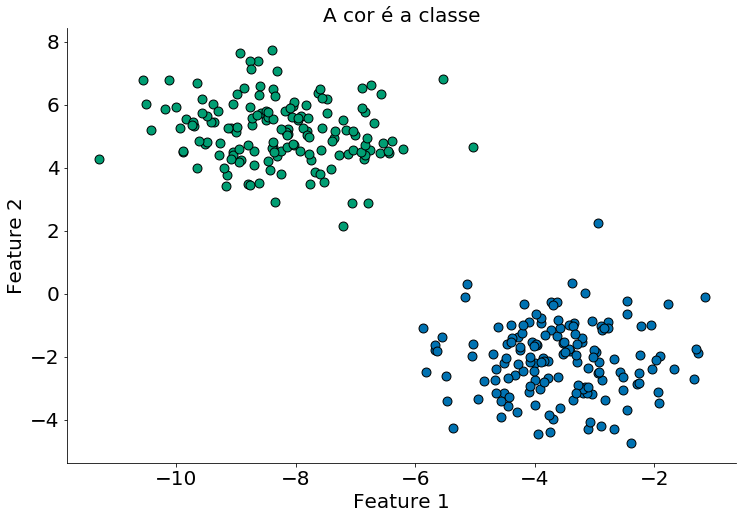

In [29]:
X, y = datasets.make_blobs(n_samples=300, centers=2, n_features=2)
ones = y == 1
plt.scatter(X[:, 0][ones], X[:, 1][ones], edgecolors='k', s=80)
plt.scatter(X[:, 0][~ones], X[:, 1][~ones], edgecolors='k', s=80)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('A cor é a classe')
despine()

In [30]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = SGDClassifier(loss='log', penalty='none', fit_intercept=False, max_iter=1000, tol=1e-3)
model = model.fit(X_train, y_train)

In [31]:
(model.predict(X_test) == y_test).mean()

1.0

## Para explorar

* O `scikit-learn` possui módulos tanto para [regressão logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) quanto para um mundo de outros classificadores.